In [1]:
%reload_ext autoreload

%reset

import numpy as np
from scipy.stats import poisson
from astropy import units

import healpy as hp

import matplotlib.pyplot as pl
import matplotlib

#For making corner plots
from getdist import plots, MCSamples

import pdb

import EPDFABC as epdfabc
import subhalos as subs


matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


<ipython-input-1-26b4495544e5>:24: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  matplotlib.rcParams['text.latex.unicode'] = True


In [2]:
# Settings for subhalo analysis

physics_settings, obs_settings, fft_settings = subs.get_settings(fft_type = 'fast')

#Set M_min to be larger so we don't have tons of sourcs
physics_settings['M_min'] = 1000.0

N_side = 32
N_pix = 12*N_side**2
N_E_bins = 5
obs_settings['Omega_pixel'] = 4.*np.pi/N_pix

print(physics_settings)
print(obs_settings)

{'R_G': 220, 'd_sun': 8.5, 'psi': 0.6981317007977318, 'M_max': 10000000000.0, 'nside_map': 2048, 'M_min': 1000.0, 'PhiPP': 1.0, 'n': 0, 'beta': 1.9}
{'area': 2000.0, 'obs_time': 10.0, 'fov_factor': 0.2, 'Omega_pixel': 0.0010226538585904274}


In [3]:
'''
def mass_function1(params, mass, distance):
    A = 1.2*10**4 #(solar mass)^-1 kpc^-3
    beta = 1.9
    return A*mass**-(beta)

def luminosity_relation1(params, mass, distance):
    #draw from luminosity distribution (gaussian) for each mass to get a luminosity
    f_SUSY = 10**-28 #cm^3 s^-1 Gev^-2
    mu = 77.4 + 0.87*np.log(mass/10**5) - 0.23*np.log(distance/50) + np.log(f_SUSY*10**28)
    sigma = 0.74 - 0.0030*np.log(mass/10**5) - 0.011*np.log(distance/50)
    cdf_values = np.random.rand(len(mass))
    luminosities = np.exp(mu + sigma*np.sqrt(2)*scipy.special.erfinv(2*cdf_values - 1))
    return luminosities
'''

#set up wrappers 
def massfunc_wrapper(params, mass, distance):
    mass_func = subs.mass_function(physics_settings, mass, gc_distance = distance)
    return mass_func

def lum_wrapper(params, mass, distance):
    this_physics_settings = physics_settings.copy()
    this_physics_settings['PhiPP'] = params[0]
    mean_lnL, sigma_lnL = subs.get_meansigma_lnL(physics_settings, mass, gc_distance = 8.5)
    luminosities = np.exp(np.random.normal(loc = mean_lnL, scale = sigma_lnL, size = len(mass)))
    return luminosities
    
def spec_wrapper(params, energy):
    param_dict = {'power_law':params[1]}
    return subs.mock_spectrum(param_dict, energy)


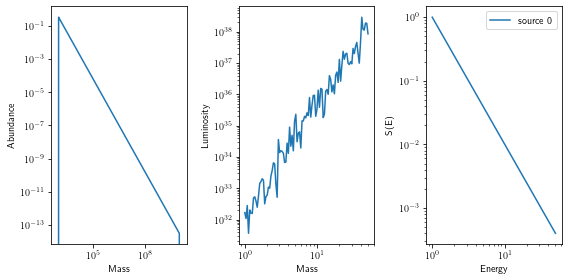

In [4]:
abun_lum_spec = [[massfunc_wrapper, lum_wrapper, spec_wrapper]]
isotropic = True
energy_range = np.array([1., 50.])
count_range = np.array([0., 100.])
param_names = ['PhiPP', 'alpha']
param_labels = ['\\Phi_{PP}', '\\alpha']
param_min = np.array([0.1, -4.])
param_max = np.array([1000.0, 0.])
param_range = [param_min, param_max]

Rmax = 10 #kpc #CHECK THIS
fov_factor = obs_settings['fov_factor']
obs_time = obs_settings['obs_time']
area = obs_settings['area']
exposure = fov_factor*(area*obs_time)

param_true = np.array([100.0, -2.])

mass_range = np.array([physics_settings['M_min'], physics_settings['M_max']])

energies = np.exp(np.linspace(np.log(energy_range[0]), np.log(energy_range[1]), num = 100))
masses = np.exp(np.linspace(np.log(mass_range[0]), np.log(mass_range[1]), num = 100))

fig, ax = pl.subplots(1,3, figsize = (8,4))
for si in range(0,len(abun_lum_spec)):
    ax[0].plot(masses, abun_lum_spec[si][0](param_true, masses, np.ones(100)), label = 'source '+str(si))
    ax[1].plot(energies, abun_lum_spec[si][1](param_true, masses, np.ones(100)), label = 'source '+str(si))
    ax[2].plot(energies, abun_lum_spec[si][2](param_true, energies), label = 'source '+str(si))
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')
ax[0].set_xlabel('Mass')
ax[1].set_xlabel('Mass')
ax[2].set_xlabel('Energy')
ax[0].set_ylabel('Abundance')
ax[1].set_ylabel('Luminosity')
ax[2].set_ylabel('S(E)')
ax[2].legend()
fig.tight_layout()

In [5]:
def lnprior(params):
    return 0.

#initialize the EPDFABC object
my_abc = epdfabc.EPDFABC(param_range)
my_abc.setup_unbinned(abun_lum_spec, energy_range, mass_range, Rmax, exposure, verbose = True)
my_abc.add_lnprior(lnprior)

Analysis Type: unbinned
N_parameters =  2
parameter min =  [ 0.1 -4. ]
parameter max =  [1000.    0.]
Emin =  1.0
Emax =  50.0
Mmin =  1000.0
Mmax =  10000000000.0
Rmax =  10
N_source_classes =  1
prior added


In [6]:
#demonstrates generating sources
source_info = my_abc.create_sources(param_true)
print("number of sources = ", source_info['masses'].shape)


num sources =  2099829
{'masses': array([2033.80030585, 2763.38529005, 1426.11370719, ..., 1758.91659033,
       1119.56431948, 2240.5278693 ]), 'distances': array([5.65272705, 1.33220051, 6.38480077, ..., 4.08403728, 1.83577674,
       7.74554135]), 'angles': array([[2.89209577, 0.29041514],
       [1.57344812, 1.03730063],
       [2.70953517, 2.73598442],
       ...,
       [1.15561426, 3.24187875],
       [0.50785402, 5.39945421],
       [1.597308  , 3.69501741]]), 'luminosities': array([1.43503348e+32, 3.50868063e+32, 1.07956413e+32, ...,
       1.16370489e+32, 9.45663503e+31, 1.21975744e+32]), 'types': array([0., 0., 0., ..., 0., 0., 0.])}
number of sources =  (2099829,)


In [7]:
#demonstrates generating photons from sources
photon_info = my_abc.generate_photons_from_sources(param_true, source_info)

{'angles': array([[0.64027092, 1.38555917],
       [1.44916347, 4.12608545],
       [0.08088761, 1.02023936],
       ...,
       [0.09524958, 1.01139132],
       [1.06314756, 5.65076418],
       [1.50709008, 2.71743205]]), 'energies': array([5.08333333, 1.        , 1.        , ..., 6.10416667, 1.        ,
       1.        ])}


In [8]:
#Create mock data with "true" parameters by generating sources and photons
obs_data_unbinned = my_abc.generate_mock_data_unbinned(param_true)


num sources =  2099829
{'masses': array([1253.42426546, 1403.28908479, 1846.14694632, ..., 5620.17384808,
       1016.26508939, 1472.88272391]), 'distances': array([7.5848035 , 3.65019516, 4.08763744, ..., 0.82236118, 2.09842214,
       2.47386516]), 'angles': array([[1.12293614, 6.02615542],
       [1.94320962, 5.16636939],
       [1.32664246, 2.89220012],
       ...,
       [1.78845012, 2.35134265],
       [1.35301059, 1.46289415],
       [1.57793752, 5.21961427]]), 'luminosities': array([1.39723773e+32, 1.12910302e+32, 8.95239568e+31, ...,
       5.36419520e+32, 6.61900225e+31, 5.94042722e+32]), 'types': array([0., 0., 0., ..., 0., 0., 0.])}
{'angles': array([[0.18877637, 0.60341211],
       [1.17723887, 1.0913541 ],
       [1.44717299, 3.60349588],
       ...,
       [1.07611868, 5.80634056],
       [0.49374778, 0.34869795],
       [0.85385232, 5.90439336]]), 'energies': array([ 1.        ,  3.04166667,  3.04166667, ...,  1.        ,
       35.70833333,  1.        ])}


(12288, 5)
max val =  100.0


<ipython-input-9-40011ecb9fbb>:6: RuntimeWarning: divide by zero encountered in log
  hp.mollview(np.log(map_test[:,0]))


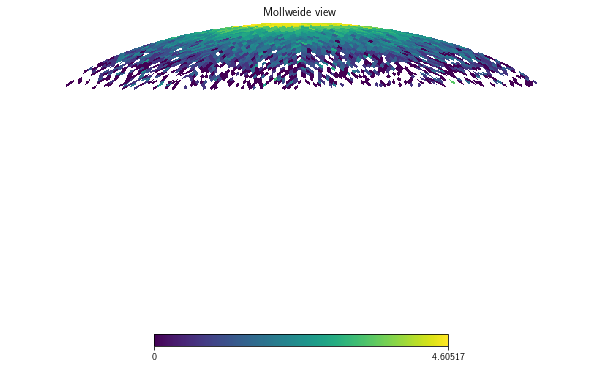

In [9]:
#convert unbinned data to map
map_test = my_abc.get_map_from_unbinned(photon_info, N_pix, N_E_bins, map_type = 'internal')
print(map_test.shape)
print("max val = ", np.max(map_test))

hp.mollview(np.log(map_test[:,0]))


In [10]:
#Get posterior using ABC
N_samples = 100
N_energy = 5
posterior_samples = my_abc.run_abc_unbinned(obs_data, N_samples, N_energy, epsilon = 100.)
print("posterior samples shape = ", posterior_samples.shape)

NameError: name 'obs_data' is not defined

In [ ]:
if (1):
    #Getdist requires specification of parameter ranges to get accurate contours
    ranges = {}
    markers={} #true parameter values
    for ii in range(0,len(param_min)):
        ranges[param_names[ii]] = [param_min[ii], param_max[ii]]
        markers[param_names[ii]] = param_true[ii]
        
    psamps = MCSamples(samples = posterior_samples, ranges = ranges, names = param_names, labels = param_labels)    


    g = plots.get_subplot_plotter()
    g.settings.title_limit_fontsize = 16 # reference size for 3.5 inch subplot
    g.settings.axes_fontsize=18
    g.settings.legend_fontsize = 26
    g.settings.axes_labelsize = 22
    g.triangle_plot(psamps, filled=True, markers=markers)